In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam

In [32]:
dataset = pd.read_csv("coords.csv",index_col=False)
dataset.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,A,0.530803,0.581163,-1.472346e-06,0.413990,0.501149,-0.018073,0.355407,0.369223,-0.029657,...,-0.057639,0.605741,0.320499,-0.091212,0.588447,0.400885,-0.071050,0.594126,0.455363,-0.044118
1,A,0.503664,0.616673,-1.548741e-06,0.377512,0.536617,-0.016148,0.317852,0.408111,-0.028432,...,-0.057488,0.561715,0.359349,-0.085140,0.546541,0.440563,-0.067003,0.551058,0.498263,-0.044481
2,A,0.267808,0.670679,-8.506087e-07,0.187360,0.610215,-0.020350,0.141140,0.503103,-0.030225,...,-0.043488,0.369881,0.461587,-0.075160,0.362212,0.517269,-0.059621,0.349507,0.565708,-0.036153
3,A,0.289091,0.751779,-1.795283e-06,0.167962,0.654705,-0.030267,0.100007,0.499485,-0.048589,...,-0.059609,0.393687,0.455553,-0.107050,0.365366,0.547497,-0.087988,0.356335,0.612805,-0.058007
4,A,0.285160,0.762803,-1.769840e-06,0.161197,0.667723,-0.030836,0.094453,0.512100,-0.048447,...,-0.059550,0.388296,0.466932,-0.105277,0.361084,0.560643,-0.085365,0.352804,0.623975,-0.055310


In [33]:
dataset = dataset.sample(frac=1)
dataset.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
12366,F,0.544936,0.738639,-1.854814e-07,0.427920,0.634468,-0.031370,0.346604,0.511367,-0.052643,...,-0.073663,0.871358,0.356649,-0.108195,0.893597,0.285638,-0.123308,0.887661,0.228563,-0.131590
55885,Y,0.573280,0.853956,-6.157141e-07,0.495882,0.811011,-0.025449,0.438135,0.750147,-0.040570,...,-0.030646,0.692039,0.682627,-0.060879,0.720518,0.656002,-0.065843,0.745053,0.631073,-0.061398
2957,B,0.667952,0.821011,6.201376e-07,0.543185,0.768543,-0.049613,0.450192,0.669005,-0.077175,...,-0.076341,0.732392,0.385297,-0.100425,0.725890,0.316687,-0.109202,0.718197,0.257635,-0.115481
34102,O,0.594720,0.589327,-7.821563e-07,0.504903,0.581307,-0.021725,0.430946,0.542984,-0.032626,...,0.001277,0.502178,0.301569,-0.007132,0.452931,0.303505,-0.010894,0.419016,0.328406,-0.011252
21045,I,0.450404,0.788857,-1.156195e-06,0.296507,0.666854,-0.049063,0.223400,0.503302,-0.069306,...,0.018939,0.552315,0.254940,0.003705,0.549412,0.152141,0.008938,0.549858,0.068836,0.027799


In [34]:
data = dataset.copy(deep = True)

In [35]:
# One-hot encode the class labels
encoder = OneHotEncoder(sparse=False)
class_labels = dataset['class'].values.reshape(-1, 1)
class_labels_encoded = encoder.fit_transform(class_labels)

# Dropping the 'class' column from the dataset
features = dataset.drop('class', axis=1)

# Standardize the feature columns
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/Users/pauljohnmaddala/anaconda3/envs/tfenv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
# Since we don't have a time series, we will treat each coordinate set (x, y, z) as one time step.
# This means we have 21 time steps with 3 features each.
features_reshaped = features_scaled.reshape((features_scaled.shape[0], 21, 3))

#features = features.to_numpy()

#features_reshaped = features.reshape((features.shape[0], 21, 3))


In [37]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_reshaped, class_labels_encoded, test_size=0.2, random_state=42
)

In [38]:
# Define the LSTM model
model_Base = Sequential()
model_Base.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model_Base.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model_Base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_Base.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
1602/1602 [==============================] - 5s 3ms/step - loss: 1.2841 - accuracy: 0.6044 - val_loss: 0.6271 - val_accuracy: 0.7987
Epoch 2/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.3075 - accuracy: 0.9051 - val_loss: 0.4156 - val_accuracy: 0.8545
Epoch 3/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.2066 - accuracy: 0.9383 - val_loss: 0.2254 - val_accuracy: 0.9263
Epoch 4/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1546 - accuracy: 0.9545 - val_loss: 0.1218 - val_accuracy: 0.9646
Epoch 5/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1237 - accuracy: 0.9635 - val_loss: 0.1603 - val_accuracy: 0.9541
Epoch 6/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1071 - accuracy: 0.9693 - val_loss: 0.1432 - val_accuracy: 0.9543
Epoch 7/20
1602/1602 [==============================] - 5s 3ms/step - loss: 0.0953 - accuracy: 0.9731 - val_loss: 0.0926 - val_accuracy:

In [39]:
# Evaluate the model
loss, accuracy_base = model_Base.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy_base*100:.2f}%')

Test Accuracy: 97.35%


In [40]:
data

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
12366,F,0.544936,0.738639,-1.854814e-07,0.427920,0.634468,-0.031370,0.346604,0.511367,-0.052643,...,-0.073663,0.871358,0.356649,-0.108195,0.893597,0.285638,-0.123308,0.887661,0.228563,-0.131590
55885,Y,0.573280,0.853956,-6.157141e-07,0.495882,0.811011,-0.025449,0.438135,0.750147,-0.040570,...,-0.030646,0.692039,0.682627,-0.060879,0.720518,0.656002,-0.065843,0.745053,0.631073,-0.061398
2957,B,0.667952,0.821011,6.201376e-07,0.543185,0.768543,-0.049613,0.450192,0.669005,-0.077175,...,-0.076341,0.732392,0.385297,-0.100425,0.725890,0.316687,-0.109202,0.718197,0.257635,-0.115481
34102,O,0.594720,0.589327,-7.821563e-07,0.504903,0.581307,-0.021725,0.430946,0.542984,-0.032626,...,0.001277,0.502178,0.301569,-0.007132,0.452931,0.303505,-0.010894,0.419016,0.328406,-0.011252
21045,I,0.450404,0.788857,-1.156195e-06,0.296507,0.666854,-0.049063,0.223400,0.503302,-0.069306,...,0.018939,0.552315,0.254940,0.003705,0.549412,0.152141,0.008938,0.549858,0.068836,0.027799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,D,0.509634,0.948830,-3.173397e-07,0.400603,0.900872,-0.003383,0.328751,0.810768,-0.024631,...,-0.096039,0.373334,0.592465,-0.130136,0.300532,0.593418,-0.132346,0.263799,0.631488,-0.125428
54011,X,0.545854,0.544462,-3.782280e-07,0.478194,0.496838,-0.018536,0.433567,0.434329,-0.028777,...,-0.031976,0.622843,0.362683,-0.056083,0.594289,0.395130,-0.049286,0.582595,0.432643,-0.038324
14984,G,0.233454,0.449567,-3.105705e-07,0.178403,0.373647,-0.025916,0.174802,0.277639,-0.036873,...,-0.050362,0.408700,0.331391,-0.087306,0.365192,0.363674,-0.071107,0.334583,0.396168,-0.047291
15626,G,0.128480,0.526536,4.246395e-07,0.064615,0.412387,-0.061215,0.095096,0.278999,-0.095136,...,-0.133550,0.382772,0.476533,-0.206874,0.305292,0.508867,-0.188753,0.240287,0.535760,-0.155334


In [41]:
# Separate features and target variable
X = data.drop('class', axis=1)
y = data['class']

# Encoding the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [42]:
X

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
12366,0.544936,0.738639,-1.854814e-07,0.427920,0.634468,-0.031370,0.346604,0.511367,-0.052643,0.322795,...,-0.073663,0.871358,0.356649,-0.108195,0.893597,0.285638,-0.123308,0.887661,0.228563,-0.131590
55885,0.573280,0.853956,-6.157141e-07,0.495882,0.811011,-0.025449,0.438135,0.750147,-0.040570,0.425703,...,-0.030646,0.692039,0.682627,-0.060879,0.720518,0.656002,-0.065843,0.745053,0.631073,-0.061398
2957,0.667952,0.821011,6.201376e-07,0.543185,0.768543,-0.049613,0.450192,0.669005,-0.077175,0.468831,...,-0.076341,0.732392,0.385297,-0.100425,0.725890,0.316687,-0.109202,0.718197,0.257635,-0.115481
34102,0.594720,0.589327,-7.821563e-07,0.504903,0.581307,-0.021725,0.430946,0.542984,-0.032626,0.386454,...,0.001277,0.502178,0.301569,-0.007132,0.452931,0.303505,-0.010894,0.419016,0.328406,-0.011252
21045,0.450404,0.788857,-1.156195e-06,0.296507,0.666854,-0.049063,0.223400,0.503302,-0.069306,0.312203,...,0.018939,0.552315,0.254940,0.003705,0.549412,0.152141,0.008938,0.549858,0.068836,0.027799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,0.509634,0.948830,-3.173397e-07,0.400603,0.900872,-0.003383,0.328751,0.810768,-0.024631,0.258079,...,-0.096039,0.373334,0.592465,-0.130136,0.300532,0.593418,-0.132346,0.263799,0.631488,-0.125428
54011,0.545854,0.544462,-3.782280e-07,0.478194,0.496838,-0.018536,0.433567,0.434329,-0.028777,0.461022,...,-0.031976,0.622843,0.362683,-0.056083,0.594289,0.395130,-0.049286,0.582595,0.432643,-0.038324
14984,0.233454,0.449567,-3.105705e-07,0.178403,0.373647,-0.025916,0.174802,0.277639,-0.036873,0.216330,...,-0.050362,0.408700,0.331391,-0.087306,0.365192,0.363674,-0.071107,0.334583,0.396168,-0.047291
15626,0.128480,0.526536,4.246395e-07,0.064615,0.412387,-0.061215,0.095096,0.278999,-0.095136,0.172362,...,-0.133550,0.382772,0.476533,-0.206874,0.305292,0.508867,-0.188753,0.240287,0.535760,-0.155334


In [43]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [44]:
# Reshape input to the shape of your data
input_shape = X_train.shape[1:]

In [45]:
input_shape

(63,)

In [46]:
# Define the CNN model
model_cnn = Sequential()
#model_cnn.add(Flatten(input_shape=input_shape))
model_cnn.add(Dense(128, input_shape=(63,), activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model_cnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
801/801 [==============================] - 1s 498us/step - loss: 1.3021 - accuracy: 0.6956 - val_loss: 0.4671 - val_accuracy: 0.9009
Epoch 2/20
801/801 [==============================] - 0s 445us/step - loss: 0.3524 - accuracy: 0.9273 - val_loss: 0.2808 - val_accuracy: 0.9524
Epoch 3/20
801/801 [==============================] - 0s 443us/step - loss: 0.2449 - accuracy: 0.9503 - val_loss: 0.2226 - val_accuracy: 0.9569
Epoch 4/20
801/801 [==============================] - 0s 444us/step - loss: 0.1947 - accuracy: 0.9605 - val_loss: 0.1781 - val_accuracy: 0.9687
Epoch 5/20
801/801 [==============================] - 0s 444us/step - loss: 0.1615 - accuracy: 0.9669 - val_loss: 0.1617 - val_accuracy: 0.9644
Epoch 6/20
801/801 [==============================] - 0s 445us/step - loss: 0.1381 - accuracy: 0.9703 - val_loss: 0.1462 - val_accuracy: 0.9685
Epoch 7/20
801/801 [==============================] - 0s 443us/step - loss: 0.1250 - accuracy: 0.9733 - val_loss: 0.1178 - val_accuracy:

In [47]:
# Evaluate the model
loss, accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_cnn*100:.2f}%")


401/401 [==============================] - 0s 245us/step - loss: 0.0711 - accuracy: 0.9831
Test Accuracy: 98.31%


In [19]:
# Perform PCA to reduce dimensionality
#pca = PCA(n_components=63)  # Maximum possible components
#X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

# Define new dimensions for the CNN-LSTM input
num_time_steps = 7  # Adjust this based on your requirements
height, width = 3, 3  # New dimensions that multiply to <= 63
channels = 1  # Grayscale

x_train_sl = scaler.fit_transform(X_train)
x_test_sl = scaler.fit_transform(X_test)

# Reshape data for CNN-LSTM input
#X_train_pca = X_train_pca.reshape(-1, num_time_steps, height, width, channels)
#X_test_pca = X_test_pca.reshape(-1, num_time_steps, height, width, channels)


X_train_pca = x_train_sl.reshape(-1, num_time_steps, height, width, channels)
X_test_pca = x_test_sl.reshape(-1, num_time_steps, height, width, channels)

In [20]:
# Define the CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (2, 2), activation='relu'), input_shape=(num_time_steps, height, width, channels)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(20))
model.add(Dense(10, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pca, y_train, epochs=20, batch_size=64, validation_data=(X_test_pca, y_test))

Epoch 1/20
801/801 [==============================] - 4s 4ms/step - loss: 2.2874 - accuracy: 0.2885 - val_loss: 1.3601 - val_accuracy: 0.5294
Epoch 2/20
801/801 [==============================] - 3s 4ms/step - loss: 1.0291 - accuracy: 0.6668 - val_loss: 0.7855 - val_accuracy: 0.7579
Epoch 3/20
801/801 [==============================] - 3s 3ms/step - loss: 0.6446 - accuracy: 0.8039 - val_loss: 0.6191 - val_accuracy: 0.7996
Epoch 4/20
801/801 [==============================] - 3s 3ms/step - loss: 0.4550 - accuracy: 0.8622 - val_loss: 0.3963 - val_accuracy: 0.8765
Epoch 5/20
801/801 [==============================] - 3s 3ms/step - loss: 0.3689 - accuracy: 0.8899 - val_loss: 0.3254 - val_accuracy: 0.9038
Epoch 6/20
801/801 [==============================] - 3s 3ms/step - loss: 0.3104 - accuracy: 0.9063 - val_loss: 0.3109 - val_accuracy: 0.9037
Epoch 7/20
801/801 [==============================] - 3s 3ms/step - loss: 0.2654 - accuracy: 0.9202 - val_loss: 0.2389 - val_accuracy: 0.9300
Epoch 

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pca, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

401/401 [==============================] - 0s 764us/step - loss: 0.0912 - accuracy: 0.9756
Test Accuracy: 97.56%


In [22]:
temp_pred_data = data.columns.values.tolist()
pred_data = pd.DataFrame(columns = temp_pred_data)
pred_data

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21


In [23]:
alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [24]:
import mediapipe as mp
#scaler = StandardScaler()
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_drawing_styles = mp.solutions.drawing_styles
def coord(image):
    try:
        with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:
            image = cv2.flip(image, 1)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = hands.process(image)
            if not results.multi_hand_landmarks:
                pass
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()
            for hand_landmarks in results.multi_hand_landmarks:
                hands = results.multi_hand_landmarks[0].landmark
                hand_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in hands]).flatten())
                #pred_data.loc[0] = hand_row
                single_sample_scaled = scaler.transform([hand_row])  # The input must be 2D for the scaler

                # Reshape the sample to add the batch and time step dimensions
                single_sample_reshaped = single_sample_scaled.reshape(1, 21, 3)

                
                return single_sample_reshaped
    except Exception as e:
        print(e)

In [25]:
def eda_cnn_lstm(cds):
    # Perform PCA to reduce dimensionality
    #pca = PCA(n_components=63)  # Maximum possible components
    #cds_pca = pca.fit_transform(cds)

    # Define new dimensions for the CNN-LSTM input
    num_time_steps = 7  # Adjust this based on your requirements
    height, width = 3, 3  # New dimensions that multiply to <= 63
    channels = 1  # Grayscale

    # Reshape data for CNN-LSTM input
    cds_pca = cds.reshape(-1, num_time_steps, height, width, channels)
    
    return cds_pca


def eda_cnn(cds):
    cds_cnn = pre.reshape(1, -1) 
    return cds_cnn

In [50]:
# Sample data for the graph
accuracy_values = {
    "accuracy_cnn_lstm": accuracy*100,       # Replace with actual accuracy value
    "accuracy_cnn": accuracy_cnn*100,   # Replace with actual accuracy for CNN
    "accuracy_base": accuracy_base*100   # Replace with actual baseline accuracy
}

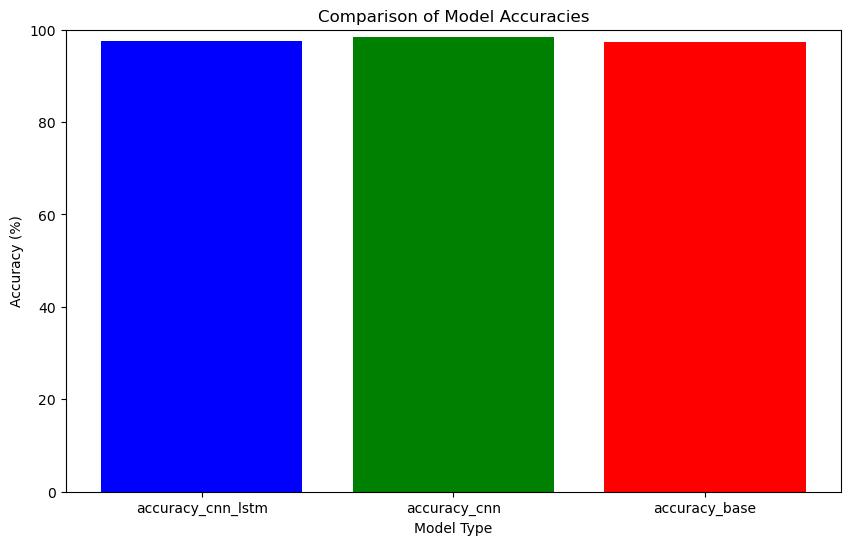

In [51]:
import matplotlib.pyplot as plt

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(accuracy_values.keys(), accuracy_values.values(), color=['blue', 'green', 'red'])

plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100

plt.show()

In [ ]:
from time import time
from collections import Counter
cam = cv2.VideoCapture(0)
previous = time()
delta = 0
s = ''

while True:
    # Get the current time, increase delta and update the previous variable
    current = time()
    delta += current - previous
    previous = current
    #t.sleep(30)
    # Check if 3 (or some other value) seconds passed
    if delta > 3:
        # Operations on image
        # Reset the time counter
        delta = 0
        # Show the image and keep streaming
        _, img = cam.read()
        cv2.imshow("Frame", img)
        cds = coord(img)
        print(type(cds))
        
        cnn_lstm_flag = 0
        cnn_flag = 0
        base = 0
        
        try:
            print("entering 1st try")
            #cds = cds.reshape(1,-1)
            try:
                #print("entering cnn lstm")
                cds_cnn_lstm = eda_cnn_lstm(cds)
                cnn_lstm_prediction = model.predict(cds_cnn_lstm)
                predicted_index_cnn_lstm = np.argmax(cnn_lstm_prediction, axis=1)[0]
                cnn_lstm_flag = 1
                
            except:
                pass
            
            try:
                #print("entering lstm try")
                base_prediction = model_Base.predict(cds)
                predicted_index_base = np.argmax(base_prediction, axis=1)[0]
                base_flag = 1
                
            except:
                pass
            
            try:
                #print("entering cnn try")
                cds_cnn = eda_cnn(cds)
                cnn_prediction = model_cnn.predict(cds_cnn)
                predicted_index_cnn = np.argmax(cnn_prediction, axis=1)[0]
                cnn_flag = 1
            
            except:
                pass
            
            
            '''if (cnn_lstm_flag == 1 and base_flag == 1 and cnn_flag == 1):
                print(alphabets[predicted_index_base], alphabets[predicted_index_cnn], alphabets[predicted_index_cnn_lstm])
            elif(cnn_lstm_flag == 0 and base_flag == 1 and cnn_flag == 1):
                print("No cnn_lstm")
                print(alphabets[predicted_index_base], alphabets[predicted_index_cnn])
            elif(cnn_lstm_flag == 1 and base_flag == 0 and cnn_flag == 1):
                print("No base_flag")
                print(alphabets[predicted_index_cnn_lstm], alphabets[predicted_index_cnn])
            elif(cnn_lstm_flag == 1 and base_flag == 1 and cnn_flag == 0):
                print("No cnn")
                print(alphabets[predicted_index_base], alphabets[predicted_index_cnn_lstm])
            else:
                print("Only one model")'''
            
            #print(predicted_index)
            lst = [alphabets[predicted_index_base], alphabets[predicted_index_cnn], alphabets[predicted_index_cnn_lstm]]
            #print(lst)
            if len(lst) != len(set(lst)):
                #print("entered if")
                duplicates = [item for item, count in Counter(lst).items() if count > 1]
                print(duplicates[0])
                s += duplicates[0]
                if len(s) == 7:
                    break
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
        except:
            pass
    cv2.waitKey(1)